In [24]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import matplotlib
import matplotlib.pyplot as plt

In [25]:
# Loads human responses and applies minimal preprocessing
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']

prob_dict = dict()

human_df = pd.read_csv('human_responses.csv')
human_df = human_df.fillna('')

for i in perms:
    prob_npz = np.load(f'problems/zerogen/all_prob_{i}_{num_alphs}.npz', allow_pickle=True)
    prob_dict[f'np_{i}'] = prob_npz['all_prob'].item()

source_1 = []
source_2 = []
target_1 = []
correct_answer = []
given_answer = []
correct = []
for nperms, alph, prob_type, prob_ind, response_string in zip(human_df['nperms'], human_df['alph'], human_df['prob_type'], human_df['prob_ind'], human_df['response_string']):
    incorrect = False
    # get the problem and split into source and target
    prob = prob_dict[nperms][alph][prob_type]['prob'][int(prob_ind)]
    source_1.append(prob[0][0])
    source_2.append(prob[0][1])
    target_1.append(prob[1][0])
    # set the 'correct' answer to the problem
    if prob_type == 'attn':
        correct_answer.append(['a', 'a', 'a', 'a'])
    else:
        correct_answer.append(prob[1][1])

    given_answer.append([a for a in list(response_string) if a not in ' []']) # strip off whitespace and [ ]

    # check if answer is correct
    if len(correct_answer[-1]) != len(given_answer[-1]):
        incorrect = 1
    else:
        incorrect = sum([a!=b for a, b in zip(correct_answer[-1], given_answer[-1])])
    c = not incorrect
    correct.append(c)

human_df['source_1'] = source_1
human_df['source_2'] = source_2
human_df['target_1'] = target_1
human_df['correct_answer'] = correct_answer
human_df['given_answer'] = given_answer
human_df['correct'] = correct
human_df['total'] = 1

# calculate top level accuracy, not including performance on attention checks
df_slice = human_df[human_df['prob_type'] != 'attn']
overall_accuracy = sum(df_slice.correct)/len(df_slice)
errs = proportion_confint(sum(df_slice.correct), len(df_slice))
print(f"Overall human accuracy is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

FileNotFoundError: [Errno 2] No such file or directory: 'human_responses.csv'

In [ ]:
# Get GPT raw responses and put into dataframe
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']

gpt_dict = dict()
prob_dict = dict()
data = []
count = 0
for gpt in models:
    gpt_dict[gpt] = dict()
    for promptstyle in promptstyles:
        gpt_dict[gpt][promptstyle] = dict()
        for i in perms:
            if promptstyle in ['webb', 'webbplus'] and i != 1:
                continue
            prob_npz = np.load(f'problems/zerogen/all_prob_{i}_{num_alphs}.npz', allow_pickle=True)
            prob_dict[f'np_{i}'] = prob_npz['all_prob'].item()
            gpt_npz = np.load(f'GPT{gpt}_predictions/gpt{gpt}_letterstring_results_{i}_multi_alph_{promptstyle}.npz', allow_pickle=True)
            gpt_dict[gpt][promptstyle][f'np_{i}'] = gpt_npz['all_prob_type_responses'].item()
            for alph in prob_dict[f'np_{i}'].keys():
                current_prob_types = list(prob_dict[f'np_{i}'][alph].keys())
                current_prob_types.remove('shuffled_letters')
                current_prob_types.remove('shuffled_alphabet')
                for j, prob_type in enumerate(current_prob_types):
                        for prob_ind in range(len(prob_dict[f'np_{i}'][alph][prob_type]['prob'])):
                            prob = prob_dict[f'np_{i}'][alph][prob_type]['prob'][int(prob_ind)]
                            gpt_response = gpt_dict[gpt][promptstyle][f'np_{i}'][alph][j][prob_ind]
                            if promptstyle =='human':
                                data.append([f'gpt_{gpt}', gpt, 'human-like', f'np_{i}', alph, prob_type, prob_ind, gpt_response])
                            else:
                                data.append([f'gpt_{gpt}', gpt, promptstyle, f'np_{i}', alph, prob_type, prob_ind, gpt_response])
                                

gpt_df = pd.DataFrame(data, columns=['subj_id','model', 'promptstyle', 'nperms', 'alph', 'prob_type', 'prob_ind', 'response_string'])
gpt_df.to_csv('data/gpt_responses.csv', index=False)


In [ ]:
# Read GPT responses from csv and apply minimal preprocessing
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb', 'webbplus']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']

prob_dict = dict()
count = 0

gpt_df = pd.read_csv('gpt_responses.csv')
gpt_df = gpt_df.fillna('')

for i in perms:
    prob_npz = np.load(f'problems/zerogen/all_prob_{i}_{num_alphs}.npz', allow_pickle=True)
    prob_dict[f'np_{i}'] = prob_npz['all_prob'].item()

source_1 = []
source_2 = []
target_1 = []
correct_answer = []
given_answer = []
correct = []
for nperms, alph, prob_type, prob_ind, response_string in zip(gpt_df['nperms'], gpt_df['alph'], gpt_df['prob_type'], gpt_df['prob_ind'], gpt_df['response_string']):
    incorrect = False
    prob = prob_dict[nperms][alph][prob_type]['prob'][int(prob_ind)]
    source_1.append(prob[0][0])
    source_2.append(prob[0][1])
    target_1.append(prob[1][0])
    if prob_type == 'attn':
        correct_answer.append(['a', 'a', 'a', 'a'])
    else:
        correct_answer.append(prob[1][1])
    first_bracket = response_string.find(']') #Truncate at first bracket
    if first_bracket != -1:
        response_string = response_string[:first_bracket]
    given_answer.append([a for a in list(response_string) if a not in ' []'])
    if len(correct_answer[-1]) != len(given_answer[-1]):
        incorrect = 1
    else:
        incorrect = sum([a!=b for a, b in zip(correct_answer[-1], given_answer[-1])])
    c = not incorrect
    correct.append(c)

gpt_df['source_1'] = source_1
gpt_df['source_2'] = source_2
gpt_df['target_1'] = target_1
gpt_df['correct_answer'] = correct_answer
gpt_df['given_answer'] = given_answer
gpt_df['correct'] = correct
gpt_df['total'] = 1

promptstyles = [ 'human-like', 'minimal', 'hw']
for n in [3, 35, 4]:
    for promptstyle in promptstyles:
        df_slice = gpt_df[(gpt_df['model']==n)&(gpt_df['promptstyle']==promptstyle)&(gpt_df['prob_type']!='attn')]
        overall_accuracy = sum(df_slice.correct)/len(df_slice)
        errs = proportion_confint(sum(df_slice.correct), len(df_slice))
        print(f"Overall accuracy for gpt {n}, promptstyle {promptstyle} is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

Overall accuracy for gpt 3, promptstyle human-like is: 0.000, confidence intervals 0.000, 0.000
Overall accuracy for gpt 3, promptstyle minimal is: 0.491, confidence intervals 0.470, 0.512
Overall accuracy for gpt 3, promptstyle hw is: 0.488, confidence intervals 0.467, 0.509
Overall accuracy for gpt 35, promptstyle human-like is: 0.093, confidence intervals 0.081, 0.105
Overall accuracy for gpt 35, promptstyle minimal is: 0.293, confidence intervals 0.273, 0.312
Overall accuracy for gpt 35, promptstyle hw is: 0.350, confidence intervals 0.330, 0.370
Overall accuracy for gpt 4, promptstyle human-like is: 0.455, confidence intervals 0.434, 0.476
Overall accuracy for gpt 4, promptstyle minimal is: 0.436, confidence intervals 0.415, 0.457
Overall accuracy for gpt 4, promptstyle hw is: 0.452, confidence intervals 0.431, 0.473


In [ ]:
# concatenate human and gpt data and save to csv

full_df = pd.concat([human_df, gpt_df])

full_df.to_csv('data/data.csv', index=False)


In [ ]:
models = ['human', 3, 35, 4]
nperms = [f'np_{i}' for i in [1, 2, 5, 10, 20, 'symb']]
promptstyles = ['human', 'human-like', 'webb', 'minimal', 'hw']

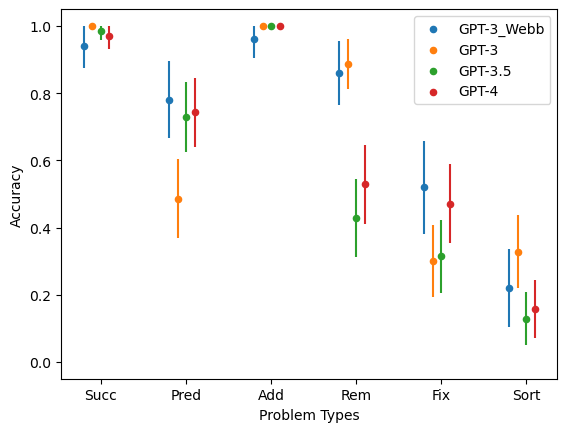

In [ ]:
# Plot results by Webb only

# Get slice of dataset using Webb's prompt
webb_df = full_df[(full_df.promptstyle=='webb')&(full_df.prob_type!='attn')]
webb_df = webb_df.groupby(['model', 'promptstyle', 'prob_type', 'nperms'], as_index=False).sum()
webb_df = webb_df.drop(columns='prob_ind')

webb_df['acc'] = webb_df['correct']/webb_df['total']
webb_df['cilow'] = proportion_confint(webb_df['correct'], webb_df['total'])[0]
webb_df['ciupp'] = proportion_confint(webb_df['correct'], webb_df['total'])[1]
webb_df['yerr_low'] = webb_df['acc']-webb_df['cilow']
webb_df['yerr_upp'] = webb_df['ciupp']-webb_df['acc']

webb_df['model'] = pd.Categorical(webb_df['model'], ordered = True, categories = models)
webb_df['promptstyle'] = pd.Categorical(webb_df['promptstyle'], ordered = True, categories = promptstyles)
webb_df['prob_type'] = pd.Categorical(webb_df['prob_type'], ordered = True, categories = prob_types)
webb_df['nperms'] = pd.Categorical(webb_df['nperms'], ordered = True, categories = nperms)
webb_df = webb_df.sort_values(['model', 'promptstyle', 'prob_type', 'nperms'])

fig, ax = plt.subplots()

# Get Webb's original data (copied from https://github.com/taylorwwebb/emergent_analogies_LLM)
webb_orig = np.load('webb_original/zerogen_acc_gpt.npz')
accs = webb_orig['all_acc']
errs = webb_orig['all_err']

scat = ax.scatter(np.arange(len(accs)), accs, s=20)
# plot the error bars, offset by the same increment, using the same facecolors
ax.errorbar(np.arange(len(accs)), accs,  yerr=errs, ls='none', color=scat.get_facecolors()[-1])

for i, model in enumerate([3, 35, 4]):
    ax.set_ylabel("Accuracy")
    df_slice = webb_df[(webb_df['model']==model)]
    
    # get the accuracies
    accs = df_slice.acc
    # get the upper and lower errors
    yerr_low = list(df_slice['yerr_low'])
    yerr_upp = list(df_slice['yerr_upp'])
    # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
    scat = ax.scatter(np.arange(len(accs)) + (i+1)*0.1, accs, s=20)
    # plot the error bars, offset by the same increment, using the same facecolors
    ax.errorbar(np.arange(len(accs)) + (i+1)*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    ax.set_xticks(np.arange(len(nperms))+0.2)
    ax.set_xticklabels(['Succ', 'Pred', 'Add', 'Rem', 'Fix', 'Sort'])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Problem Types')
ax.legend(['GPT-3_Webb','GPT-3', 'GPT-3.5', 'GPT-4'])
plt.savefig('plots/webb.pdf', bbox_inches='tight')

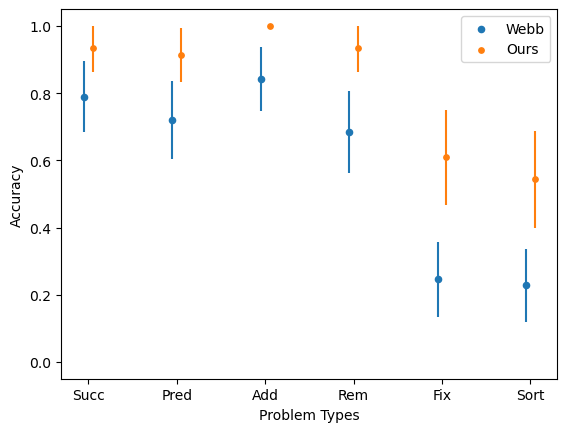

In [ ]:
# Plot our human data and Webb et al.'s human data

# Group df by model, nperms, prob_type, and promptstyle
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']
grouped_df = full_df.groupby(['model', 'promptstyle', 'nperms','prob_type'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')

grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['prob_type'] = pd.Categorical(grouped_df['prob_type'], ordered = True, categories = prob_types)
grouped_df['nperms'] = pd.Categorical(grouped_df['nperms'], ordered = True, categories = nperms)
grouped_df = grouped_df.sort_values(['model', 'prob_type', 'nperms'])

# Get human data for unpermuted alphabets not including attention checks
current_slice = grouped_df[(grouped_df.model=='human')&(grouped_df.nperms=='np_1')&(grouped_df.prob_type!='attn')]

fig, ax = plt.subplots()

# Get Webb's original data
webb_orig = np.load('webb_original/zerogen_acc_human.npz')
accs = webb_orig['all_acc']
errs = webb_orig['all_err']

scat = ax.scatter(np.arange(len(accs)), accs, s=20)
# plot the error bars, offset by the same increment, using the same facecolors
ax.errorbar(np.arange(len(accs)), accs,  yerr=errs, ls='none', color=scat.get_facecolors()[-1])

accs = current_slice['acc']

# get the upper and lower errors
yerr_low = list(current_slice['yerr_low'])
yerr_upp = list(current_slice['yerr_upp'])
# plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
scat = ax.scatter(np.arange(len(accs)) + 0.1, accs, s=15)
# plot the error bars, offset by the same increment, using the same facecolors
ax.errorbar(np.arange(len(accs)) + 0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
ax.set_xticks(np.arange(6)+0.05)
ax.set_xticklabels(['Succ', 'Pred', 'Add', 'Rem', 'Fix', 'Sort'])
# axs[].set_axis_off()
ax.set_ylim([-0.05, 1.05])
ax.legend(['Webb', 'Ours'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Types')
plt.savefig('plots/webb_human.pdf', bbox_inches='tight')

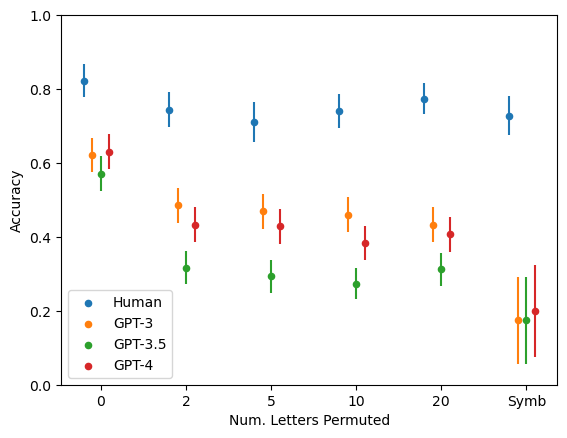

In [ ]:
# Plot human and GPT performance using the Hodel and West prompt across different numbers of letters permuted

# Group df by model, nperms and promptstyle
grouped_df = full_df[full_df.prob_type!='attn']
grouped_df = grouped_df.groupby(['model', 'promptstyle', 'nperms'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')

grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['promptstyle'] = pd.Categorical(grouped_df['promptstyle'], ordered = True, categories = promptstyles)
grouped_df['nperms'] = pd.Categorical(grouped_df['nperms'], ordered = True, categories = nperms)
grouped_df = grouped_df.sort_values(['model', 'promptstyle', 'nperms'])


fig, ax = plt.subplots()
ax.set_ylabel("Accuracy")

# Get data that is either human or uses Hodel and West prompt
df_slice = grouped_df[(grouped_df.promptstyle=='human')|(grouped_df.promptstyle=='hw')]

for j, model in enumerate(models):
    # get the accuracies
    accs = df_slice[df_slice.model == model]['acc']
    # get the upper and lower errors
    yerr_low = list(df_slice [df_slice.model == model]['yerr_low'])
    yerr_upp = list(df_slice [df_slice.model == model]['yerr_upp'])
    # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
    scat = ax.scatter(np.arange(len(accs)) + j*0.1, accs, s=20)
    # plot the error bars, offset by the same increment, using the same facecolors
    ax.errorbar(np.arange(len(accs)) + j*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    # put the legend on the last plot
    if i == 2:
        ax.legend(['Human', 'GPT-3', 'GPT-3.5', 'GPT-4']) 
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    ax.set_xticks(np.arange(len(nperms))+0.2)
    ax.set_xticklabels([0, 2, 5, 10, 20, 'Symb'])
    ax.set_xlabel('Num. Letters Permuted')
    ax.set_ylim([0, 1])
plt.savefig('plots/gpt_human.pdf', bbox_inches='tight')


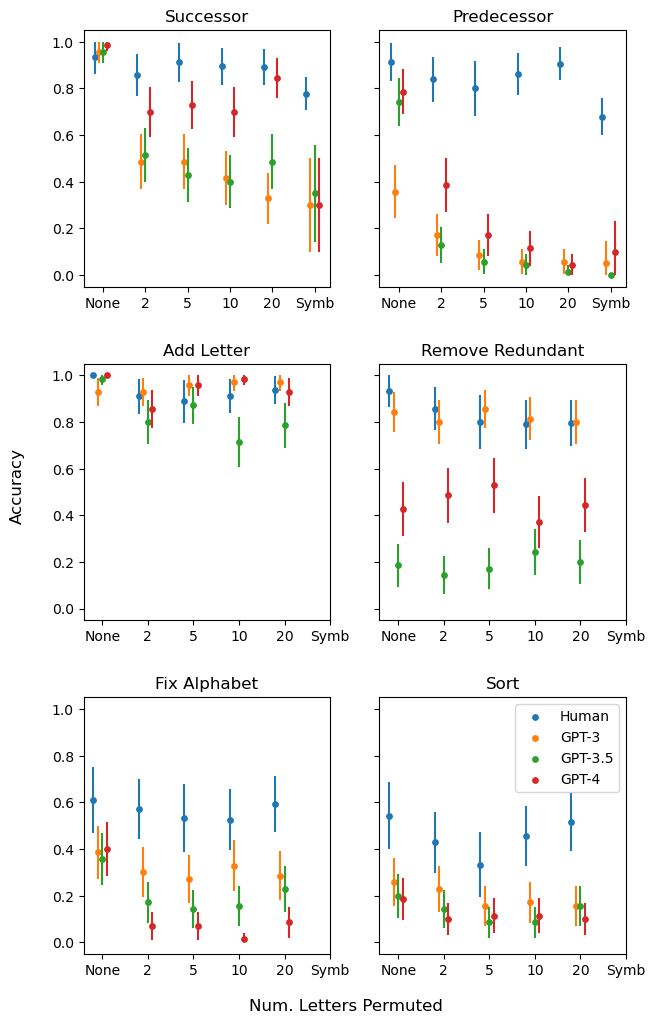

In [ ]:
# Plot human and GPT data by problem type and number of letters permuted, for Hodel and West prompt

# Group df by model, nperms, prob_type, and promptstyle
grouped_df = full_df.groupby(['model', 'promptstyle', 'prob_type', 'nperms'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')

grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['promptstyle'] = pd.Categorical(grouped_df['promptstyle'], ordered = True, categories = promptstyles)
grouped_df['prob_type'] = pd.Categorical(grouped_df['prob_type'], ordered = True, categories = prob_types)
grouped_df['nperms'] = pd.Categorical(grouped_df['nperms'], ordered = True, categories = nperms)
grouped_df = grouped_df.sort_values(['model', 'promptstyle', 'prob_type', 'nperms'])
                         
fig, axs = plt.subplots(nrows = 3, ncols=2, sharey=True, figsize=(7,12))

df_slice = grouped_df[(grouped_df.promptstyle == 'hw') | (grouped_df.promptstyle == 'human')]

titles = ['Successor', 'Predecessor', 'Add Letter', 'Remove Redundant', 'Fix Alphabet', 'Sort', 'Attention']

# plot performance by problem type
for i, prob_type in enumerate(prob_types[:-1]):
    if i < 2:
        row, col = (0, i)
    elif 2<=i < 4:
        row, col = (1, i-2)
    else:
        row, col = (2, i-4)

    axs[row, col].set_title(titles[i])
    # Get slice of df for prob type
    current_slice = df_slice[df_slice.prob_type == prob_type]
    for j, model in enumerate(models):
        # get the accuracies
        accs = current_slice[current_slice.model == model]['acc']
        # get the upper and lower errors
        yerr_low = list(current_slice[current_slice.model == model]['yerr_low'])
        yerr_upp = list(current_slice[current_slice.model == model]['yerr_upp'])
        # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
        scat = axs[row, col].scatter(np.arange(len(accs)) + j*0.1, accs, s=15)
        # plot the error bars, offset by the same increment, using the same facecolors
        axs[row, col].errorbar(np.arange(len(accs)) + j*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    axs[row, col].set_xticks(np.arange(len(nperms))+0.2)
    axs[row, col].set_xticklabels(['None', 2, 5, 10, 20, 'Symb'])
    axs[2, 1].legend(['Human', 'GPT-3', 'GPT-3.5', 'GPT-4'])


fig.subplots_adjust(hspace=0.3)
fig.supxlabel('Num. Letters Permuted', y=0.06)
fig.supylabel('Accuracy')

plt.savefig('plots/prob_types.pdf', bbox_inches='tight')